Analyse uniformity of observations

In [1]:
import sys, os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from astropy.io import ascii
%matplotlib inline

In [2]:
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as mb
from lsst.sims.utils import Site
from lsst.sims.utils import calcLmstLast


In [3]:
class SeasonUniformityMetric(metrics.BaseMetric):
    """Calculate how uniformly the observations are spaced in time.
    Returns a value between -1 and 1.
    A value of zero means the observations are perfectly uniform.

    Parameters
    ----------
    surveyLength : float, optional
        The overall duration of the survey. Default 10.
    """
    def __init__(self, observationStartMJDCol='observationStartMJD', units='',
                 season=1., surveyLength=10., **kwargs):
        """surveyLength = time span of survey (years) """
        self.observationStartMJDCol = observationStartMJDCol
        super(SeasonUniformityMetric, self).__init__(col=self.observationStartMJDCol, units=units, **kwargs)
        self.surveyLength = surveyLength
        self.season = season

    def set_season(self, season):
        self.season = season

    def run(self, dataSlice, slicePoint=None):
        """"Calculate the survey uniformity.

        This is based on how a KS-test works: look at the cumulative distribution of observation dates,
        and compare to a perfectly uniform cumulative distribution.
        Perfectly uniform observations = 0, perfectly non-uniform = 1.

        Parameters
        ----------
        dataSlice : numpy.array
            Numpy structured array containing the data related to the visits provided by the slicer.
        slicePoint : dict, optional
            Dictionary containing information about the slicepoint currently active in the slicer.

        Returns
        -------
        float
            Uniformity of 'observationStartMJDCol'.
        """
        # If only one observation, there is no uniformity
        if dataSlice[self.observationStartMJDCol].size == 1:
            return 1
        # Scale dates to lie between 0 and 1, where 0 is the first observation date and 1 is surveyLength
        dates = (dataSlice[self.observationStartMJDCol] - dataSlice[self.observationStartMJDCol].min()) / 365.25
        dates.sort()  # Just to be sure
        cycle = np.floor(dates)
        cycle_ceil = np.ceil(dates)

        season_start = dates[0]
        season_proc = season_start + self.season
        season_proc_start = dates[np.argmin(np.abs(dates-season_proc))]

        mask_season = np.bitwise_and(dates >= season_proc_start,
                                     dates <= season_proc_start+1.0)
        dates = dates[mask_season]
        dt = np.zeros_like(dates)
        dt[:-1] = dates[1:]-dates[:-1]
        mask_dt = dt<0.4
        season_break = np.where(np.bitwise_not(mask_dt))[0]
        while len(season_break) > 0:
            if season_break > len(dates)/2:
                dates = dates[:season_break[0]-1]
            else:
                dates = dates[season_break[0]+1:]

            dt = np.zeros_like(dates)
            dt[:-1] = dates[1:]-dates[:-1]
            mask_dt = dt<0.4

            season_break = np.where(np.bitwise_not(mask_dt))[0]


        dates-=season_proc
        dates.sort()

        n_cum = np.linspace(np.min(dates), np.max(dates), dates.size)
        D_max = np.max(np.abs(n_cum - dates))

        
        '''
#         dates /= 365.25
        cycle = np.floor(dates)
        cycle_ceil = np.ceil(dates)
        season_start = dates[0]
        season_proc = season_start + self.season
        season_proc_start = dates[np.argmin(np.abs(dates-season_proc))]

#         print(season_start, season_proc, season_proc_start)
        # dates -= season_proc_start
        mask_season = np.bitwise_and(dates >= season_proc_start,
                                     dates <= season_proc_start+1.0)
        dates = dates[mask_season]
        dt = np.zeros_like(dates)
        dt[:-1] = dates[1:]-dates[:-1]
        mask_dt = dt<0.4

        season_break = np.where(np.bitwise_not(mask_dt))[0]
        while len(season_break) > 0:
            if season_break > len(dates)/2:
                dates = dates[:season_break[0]-1]
            else:
                dates = dates[season_break[0]+1:]

            dt = np.zeros_like(dates)
            dt[:-1] = dates[1:]-dates[:-1]
            mask_dt = dt<0.4

            season_break = np.where(np.bitwise_not(mask_dt))[0]


#             dt = np.zeros_like(dates)
#             dt[:-1] = dates[1:]-dates[:-1]
#             mask_dt = dt<0.4

        
        dates-=season_proc
        dates[dates>0.5]-=1.
        
        dates.sort()  # Just to be sure
#         cycle = np.floor(dates)
#         cycle_ceil = np.ceil(dates)
#         season_start = dates[0]
#         season_proc = season_start + self.season
#         season_proc_start = dates[np.argmin(np.abs(dates-season_proc))]
#         mask_season = np.bitwise_and(dates >= season_proc_start,
#                                      dates <= season_proc_start+1.0)
#         dates = dates[mask_season]
#         cycle = np.floor(dates)
#         cycle_ceil = np.ceil(dates)
#         dates -= cycle
#         dates[dates>0.5] = 1.0-dates[dates>0.5]
                
#         dates.sort()
        # Check that you get a good balance between (-0.5, 0) and (0, 0.5)
#         mask_before0 = dates < 0.
#         if np.sum(mask_before0) < 0.37 * len(dates):
#             dates = dates[dates>0.]
#         elif np.sum(mask_before0) > 0.63 * len(dates):
#             dates = dates[mask_before0]
            
        n_cum = np.linspace(np.min(dates), np.max(dates), dates.size)
        D_max = np.max(np.abs(n_cum - dates))
'''
        return D_max
        

In [4]:
o = db.OpsimDatabase(os.path.expanduser('~/Data/db/astro-lsst-01_2013.db'))

In [5]:
uniformity_metric = metrics.UniformityMetric(surveyLength=10)
slicer_area = slicers.HealpixSlicer(nside=64, lonCol='fieldRA', latCol='fieldDec', latLonDeg=True)

sql = 'proposalId = 3' 

bundle_uniformity = mb.MetricBundle(uniformity_metric, slicer_area, sql)
bg = mb.MetricBundleGroup({0:bundle_uniformity}, o)
bg.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint proposalId = 3 for columns ['fieldRA', 'observationStartMJD', 'fieldDec']
Found 2037211 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


{'SkyMap': 1}

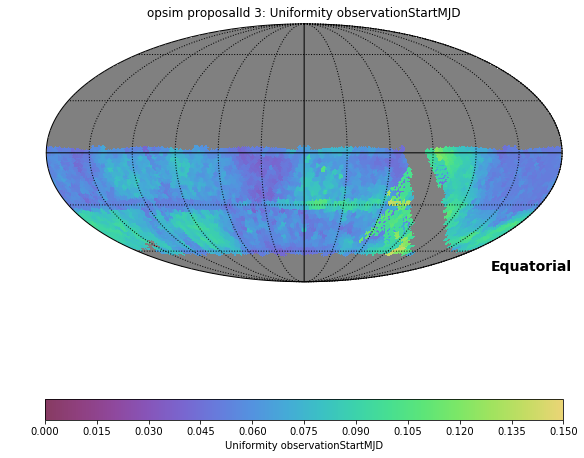

In [6]:
plotDict={'colorMin':-0., 'colorMax': 0.15, 'xMin':-0., 'xMax':0.15, 'figsize':(10,8)}
bundle_uniformity.setPlotDict(plotDict)
bundle_uniformity.plot(plotFunc=plots.HealpixSkyMap())

In [7]:
slicer_area = slicers.HealpixSlicer(nside=64, lonCol='fieldRA', latCol='fieldDec', latLonDeg=True)
uniformity_metric = metrics.UniformityMetric(surveyLength=10)
sql = 'proposalId = 3'

plotDict={'figsize':(10,8), 'title' :  'Full 10 Years - Standard Uniformity Metric',
          'colorMin':0, 'colorMax': 0.18, 'xMin':0., 'xMax':0.18,
         'bins' : np.arange(0.,0.18,0.02)-0.01}
bundle_group = {'full_10years' : mb.MetricBundle(uniformity_metric, slicer_area, sql,
                                                 plotDict=plotDict)}

# Using surveyLength=0.5 beacause each field is optimally observed for roughly ~6 months

for year in range(10):
    plotDict['title'] = 'Season %i Uniformity Metric' % (year+1)
    sql = 'proposalId = 3 and night < %i' % ((year+1)*365)    
    uniformity_metric = SeasonUniformityMetric(surveyLength=1.0, season=year) 
    bundle_group['season_%02i' % (year+1)] = mb.MetricBundle(uniformity_metric, slicer_area, sql,
                                                          plotDict=plotDict)
    
bg = mb.MetricBundleGroup(bundle_group, o)
bg.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint proposalId = 3 and night < 2190 for columns ['fieldRA', 'fieldDec', 'observationStartMJD']
Found 1215272 visits
Running:  ['season_06']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and night < 3285 for columns ['fieldRA', 'fieldDec', 'observationStartMJD']
Found 1819756 visits
Running:  ['season_09']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and night < 2920 for columns ['fieldRA', 'fieldDec', 'observationStartMJD']
Found 1637807 visits
Running:  ['season_08']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and night < 365 for column

In [8]:
plotDict={'figsize':(10,8)}
# bundle_uniformity.setPlotDict(plotDict)
# bundle_uniformity.plot(plotFunc=plots.HealpixSkyMap())
bg.plotAll()

Plotting figures with "proposalId = 3 and night < 2190" constraint now.
monopole: 0.0635252  dipole: lon: -112.561, lat: -25.4546, amp: 0.0227292
Plotting complete.
Plotting figures with "proposalId = 3 and night < 3285" constraint now.
monopole: 0.0544826  dipole: lon: -156.254, lat: -19.7766, amp: 0.0208418
Plotting complete.
Plotting figures with "proposalId = 3 and night < 2920" constraint now.
monopole: 0.0498823  dipole: lon: -140.676, lat: -52.4759, amp: 0.0156285
Plotting complete.
Plotting figures with "proposalId = 3 and night < 365" constraint now.
monopole: 0.0556851  dipole: lon: -139.389, lat: -48.2086, amp: 0.0307444
Plotting complete.
Plotting figures with "proposalId = 3 and night < 2555" constraint now.
monopole: 0.0497937  dipole: lon: -175.2, lat: -49.2858, amp: 0.0195623
Plotting complete.
Plotting figures with "proposalId = 3 and night < 3650" constraint now.
monopole: 0.0533595  dipole: lon: -132.605, lat: -69.5724, amp: 0.0212407
Plotting complete.
Plotting figu

In [5]:
uniformity_metric = SeasonUniformityMetric(surveyLength=1.0)
slicer_area = slicers.HealpixSlicer(nside=64, lonCol='fieldRA', latCol='fieldDec', latLonDeg=True)

sql = 'proposalId = 3' 

bundle_uniformity = mb.MetricBundle(uniformity_metric, slicer_area, sql)
bg = mb.MetricBundleGroup({0:bundle_uniformity}, o)
bg.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint proposalId = 3 for columns ['fieldRA', 'fieldDec', 'observationStartMJD']
Found 2037211 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


{'SkyMap': 1}

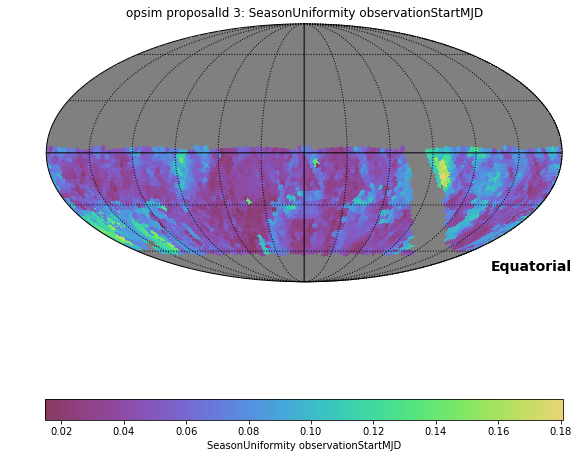

In [6]:
plotDict={'figsize':(10,8)} #, 'colorMin':-0.1, 'colorMax': 0.1, 'xMin':-0.1, 'xMax':0.1}
bundle_uniformity.setPlotDict(plotDict)
bundle_uniformity.plot(plotFunc=plots.HealpixSkyMap())

In [34]:
time_metric = metrics.PassMetric('observationStartMJD', metricName='observationStartMJD')
fiveS_metric = metrics.PassMetric('fiveSigmaDepth', metricName='fiveSigmaDepth')

slicer_observation = slicers.OneDSlicer(sliceColName='observationId') 
sql = 'proposalId = 3 and fieldId = 429 and filter = "g"' # WFD 

time_bundle = mb.MetricBundle(time_metric, slicer_observation, sql)
fiveS_bundle = mb.MetricBundle(fiveS_metric, slicer_observation, sql)

bg = mb.MetricBundleGroup({'time':time_bundle}, o)
bg.runAll()

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 429 and filter = "g" for columns ['observationId', 'observationStartMJD']
Found 79 visits
Running:  ['time']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [28]:
def unpack_values(bundle, field_name='observationStartMJD'):
    alt_size = np.sum(np.array([len(i) if i is not None else 0 for i in bundle.metricValues.data]))
    altitude = np.zeros(alt_size) # return value
    bsize1 = len(bundle.metricValues.data)
    start_index = 0

    for i in range(bsize1):
        if (bundle.metricValues.data[i] is None):
            continue
#         print(i, bundle_altitude.metricValues.data[i])
#         print(bundle_altitude.metricValues.data[i][field_name][0],bundle_altitude.metricValues.data[i][field_name][-1])
        bsize2 = len(bundle.metricValues.data[i][field_name])
        altitude[start_index:start_index+bsize2] += bundle.metricValues.data[i][field_name]
        start_index+=bsize2    
    return altitude

In [ ]:
def get_season(times, start_time=None, duration=0.5):
    '''Calculate season of each observation. A season is a blocks in time defined 
    by a `start_time` and a `duration`. All observations happened 
    in that window are taged as beeing from that season. 
    
    '''
    
    if start_time is None:
        start_time = np.min(times)
    

0.0 9.92492106497
0.0 9.92492106497
3.49202727667e-05 0.127242577756
1.19776621934


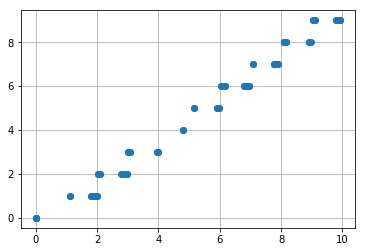

In [35]:
# print(time_bundle.metricValues.data[0]['observationStartMJD'])
# print(times)
times = unpack_values(time_bundle)
mags = np.zeros_like(times)
# mags = unpack_values(fiveS_bundle,'fiveSigmaDepth')

phase = (times-times[0])/365.25
cycle = np.floor(phase)

# phase -= cycle
# phase[phase>0.5] -= 1.0
phase.sort()
# phase = phase[1:-1]
# mags = np.zeros_like(phase)
# print(times)
# time() -= times[0])
n_cum = np.linspace(np.min(phase),np.max(phase),len(phase))

# times = times[:24]
# plt.plot((times-times[0])/365.25, 
#          mags-0.05, 
#          'o')

_cycle = cycle
_phase = phase
plt.plot(phase, 
         cycle, 
         'o')
# plt.plot(n_cum, 
#          mags+0.05, 
#          '.')

print(n_cum[0],n_cum[-1])
print(phase[0],phase[-1])
print(phase[1],n_cum[1])

print(np.max(np.abs(n_cum-phase)))

plt.grid()
# plt.xlim(1-0.01,1.51)
# plt.ylim(-0.1,1.1)

In [7]:
uniformity_metric = SeasonUniformityMetric(surveyLength=1.0,metricName='SeasonU')
slicer_fieldId = slicers.OneDSlicer(sliceColName='fieldId',
                                    bins=np.arange(308,2778)-0.5) 
# count_metric = metric.CountMetric(col='fieldId')

sql = 'proposalId = 3' 
# sql = 'proposalId = 3 and fieldId = 400 and (night > 3285 and night < 3650)' # WFD 

bundle_uniformity = mb.MetricBundle(uniformity_metric, slicer_fieldId, sql)
bg = mb.MetricBundleGroup({0:bundle_uniformity}, o)
bg.runAll()


Querying database SummaryAllProps with constraint proposalId = 3 for columns ['observationStartMJD', 'fieldId']
Found 2037211 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [8]:
# bg.plotAll(closefigs=False)
print(np.max(bundle_uniformity.metricValues.data))
print(np.argmax(bundle_uniformity.metricValues.data))
print(bundle_uniformity.slicer.bins[92])
print(bundle_uniformity.slicer.bins)

0.554700016083
794
399.5
[  307.5   308.5   309.5 ...,  2774.5  2775.5  2776.5]


163.932127918 164.932127918 165.03519523
bar
Date start: 163.932128/165.742353
Date start: 163.932128/165.742353
Date start: 163.932128/0.810225
12
0.0406352799038


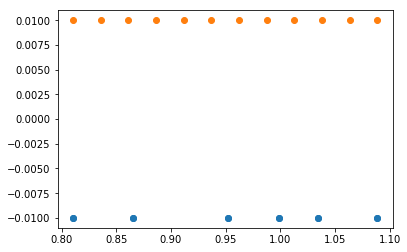

In [38]:
dates = unpack_values(time_bundle)

dates.sort()  # Just to be sure
dates /= 365.25
cycle = np.floor(dates)
cycle_ceil = np.ceil(dates)
season = 1.
season_start = dates[0]
season_proc = season_start + season
season_proc_start = dates[np.argmin(np.abs(dates-season_proc))]

print(season_start, season_proc, season_proc_start)
# dates -= season_proc_start
mask_season = np.bitwise_and(dates >= season_proc_start,
                             dates <= season_proc_start+1.0)
dates = dates[mask_season]
dt = np.zeros_like(dates)
dt[:-1] = dates[1:]-dates[:-1]
mask_dt = dt<0.4
season_break = np.where(np.bitwise_not(mask_dt))[0]
if len(season_break) > 0 and season_break > len(dates)/2:
    print('goo')
    dates = dates[:season_break[0]+1]
elif len(season_break) > 0:
    print('bar')
    dates = dates[season_break[0]+1:]

# print(np.where(np.bitwise_not(mask_dt))[0][0])
# print(dates)
# print(dt[mask_dt])
# print(dates[mask_dt])
# print(np.any(np.bitwise_not(mask_dt)))

# while np.any(np.bitwise_not(mask_dt)):
#     dates = dates[mask_dt]
#     season_start = dates[0]
#     season_proc = season_start + season
#     season_proc_start = dates[np.argmin(np.abs(dates-season_proc))]

#     mask_season = np.bitwise_and(dates >= season_proc_start,
#                                  dates <= season_proc_start+1.0)
#     dates = dates[mask_season]

#     dt = np.zeros_like(dates)
#     dt[:-1] = dates[1:]-dates[:-1]
#     mask_dt = dt<0.4
# dates = dates[mask_dt]



# print(dates)
# cycle = np.floor(dates)
# cycle_ceil = np.ceil(dates)
print('Date start: %f/%f' % (season_start,dates[0]))
# dates -= cycle
print('Date start: %f/%f' % (season_start,dates[0]))
dates-=season_proc
# print(dates[dates>season+0.5])
# print(dates[0:4])

# dates[dates>0.5] -= 1.
# print(dates[dates>0.5])

dates.sort()

print('Date start: %f/%f' % (season_start,dates[0]))

# plt.plot(_phase, 
#          _cycle, 
#          'o')
print(dates.size)
n_cum = np.linspace(np.min(dates), np.max(dates), dates.size)
D_max = np.max(np.abs(n_cum - dates))
print(D_max)


plt.plot(dates, 
         np.zeros_like(dates)-0.01, 
         'o')
plt.plot(n_cum, 
         np.zeros_like(dates)+0.01, 
         'o')



# plt.xlim(-0.1,1.1)
# plt.ylim(-0.1,0.1)

In [10]:
print(bundle_uniformity.metricValues.data)

[ 0.  0.  0. ...,  0.  0.  0.]


In [13]:
field_list = np.loadtxt(os.path.expanduser('~/Data/db/fieldId.txt'), unpack = True, dtype=np.int)

In [14]:
metric_bundle_dict = {}
for field_id in field_list:
    sql = 'proposalId = 3 and fieldId = %i and filter = "r"' % (field_id) # WFD 
    metric_bundle_dict['field_%04i' % (field_id)] = mb.MetricBundle(
        metrics.PassMetric('observationStartMJD'),
        slicers.OneDSlicer(sliceColName='observationId'), sql)
    
bg = mb.MetricBundleGroup(metric_bundle_dict, o)    
bg.runAll()    

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1137 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 210 visits
Running:  ['field_1137']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 391 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 199 visits
Running:  ['field_0391']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1923 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 219 visits
Running:  ['field_1923']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2371 and filter = "r" for columns ['observationId', 'obser

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 132 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 132 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Found 205 visits
Running:  ['field_0932']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2400 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 187 visits
Running:  ['field_2400']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2842 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1864 and filter = "r" for columns ['observationId', 'observationStartMJD']


/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2842 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2842 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Found 218 visits
Running:  ['field_1864']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 750 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 193 visits
Running:  ['field_0750']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 532 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 682 and filter = "r" for columns ['observationId', 'observationStartMJD']


/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 532 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 532 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Found 198 visits
Running:  ['field_0682']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 846 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 205 visits
Running:  ['field_0846']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1565 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 198 visits
Running:  ['field_1565']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2123 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 207 visits
Running:  ['field_2123']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Que

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3660 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3660 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3992 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 199 visits
Running:  ['field_1402']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2023 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 198 visits
Running:  ['field_2023']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4654 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 28 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 505 and filter = "r" for columns ['observationId', 'observationStartMJD']


/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4654 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4654 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 28 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Found 183 visits
Running:  ['field_0505']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 543 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 199 visits
Running:  ['field_0543']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1242 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 208 visits
Running:  ['field_1242']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1391 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 182 visits
Running:  ['field_1391']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Que

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3910 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3910 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3717 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 180 visits
Running:  ['field_0400']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1586 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 214 visits
Running:  ['field_1586']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2165 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 188 visits
Running:  ['field_2165']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3674 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3744 and filter = "r" for columns ['observationId', 'obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3674 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3674 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3744 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 207 visits
Running:  ['field_0968']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3491 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1844 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 217 visits
Running:  ['field_1844']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3416 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1276 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 202 visits
Running:  ['field_1276']


/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3491 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3491 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3416 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4001 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4414 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4966 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1707 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 213 visits
Running:  ['field_1707']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1863 and filter = "r" for columns ['observationId', 'observationStartMJD']


/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4001 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4001 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4414 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 186 visits
Running:  ['field_1863']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4605 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 679 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2578 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_2578']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5014 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3264 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 679 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 679 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5014 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Found 202 visits
Running:  ['field_1998']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 12 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2566 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 171 visits
Running:  ['field_2566']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2304 and filter = "r" for columns ['observationId', 'observationStartMJD']


/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 12 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 12 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Found 178 visits
Running:  ['field_2304']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5049 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 66 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2612 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 195 visits
Running:  ['field_2612']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 56 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3569 and filter = "r" for columns ['obser

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5049 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5049 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 66 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Found 204 visits
Running:  ['field_2423']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2242 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_2242']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4600 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2571 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_2571']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3763 and filter = "r" for columns ['observationId', 'obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4600 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4600 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3763 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5260 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5211 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2939 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4833 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4388 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2456 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 171 visits
Running:  ['field_2456']
Completed metric generation.
Runni

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3004 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3004 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3104 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 178 visits
Running:  ['field_1640']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1546 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_1546']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2992 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3878 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3847 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1597 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2992 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2992 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3878 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 185 visits
Running:  ['field_1597']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 529 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 189 visits
Running:  ['field_0529']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4297 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4479 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3236 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3432 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4297 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4297 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4479 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 180 visits
Running:  ['field_0457']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 569 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 197 visits
Running:  ['field_0569']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 898 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 193 visits
Running:  ['field_0898']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 985 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 174 visits
Running:  ['field_0985']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Query

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2916 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2916 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4708 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 212 visits
Running:  ['field_2082']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2906 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3671 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1124 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 168 visits
Running:  ['field_1124']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3350 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4633 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3350 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3350 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4633 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 197 visits
Running:  ['field_2297']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4541 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 606 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 202 visits
Running:  ['field_0606']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1912 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 169 visits
Running:  ['field_1912']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4783 and filter = "r" for columns ['observationId', 'obser

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4783 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4783 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4994 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1073 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_1073']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 976 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 211 visits
Running:  ['field_0976']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 778 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 174 visits
Running:  ['field_0778']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 438 and filter = "r" for columns ['observationId', 'observa

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3987 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3987 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4666 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 185 visits
Running:  ['field_1890']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4666 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3666 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 821 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 205 visits
Running:  ['field_0821']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4731 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4241 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5259 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5259 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 40 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5259 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 454 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 177 visits
Running:  ['field_0454']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 40 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1115 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 196 visits
Running:  ['field_1115']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 9

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4852 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4852 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4347 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 196 visits
Running:  ['field_1768']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4347 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 119 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1702 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 178 visits
Running:  ['field_1702']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2072 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 218 visits
Running:  ['field_2072']
Completed metric generation.
Running reduce methods.
Running summary statis

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4088 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4088 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2898 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 215 visits
Running:  ['field_1179']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2898 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1692 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 168 visits
Running:  ['field_1692']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2170 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 186 visits
Running:  ['field_2170']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4773 and filter = "r" for columns ['observationId', 'obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4773 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4773 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4225 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 183 visits
Running:  ['field_2081']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3875 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3555 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3169 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1082 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 173 visits
Running:  ['field_1082']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2494 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2913 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2913 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 954 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2913 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 954 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3265 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3732 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1360 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 203 visits
Running:  ['field_1360']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3205 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3205 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3243 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3243 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3314 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3863 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4623 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 277 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 945 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 193 visits
Running:  ['field_0945']
Completed metric generation.
Running

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3723 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3723 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4356 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 193 visits
Running:  ['field_2420']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4320 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3637 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4905 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4801 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3349 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1290 and filter =

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4320 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4320 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3637 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2445 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1633 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 182 visits
Running:  ['field_1633']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2987 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4362 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4173 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3319 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3319 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 290 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3611 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 725 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3307 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4041 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4699 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3776 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4965 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4965 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


 ['field_0995']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2149 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 218 visits
Running:  ['field_2149']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4402 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 549 and filter = "r" for columns ['observationId', 'observationStartMJD']


/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4402 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4402 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3810 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 172 visits
Running:  ['field_0549']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3810 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 577 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 211 visits
Running:  ['field_0577']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2883 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3742 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1653 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2883 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2883 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3742 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 203 visits
Running:  ['field_1485']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3015 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4628 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1114 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 172 visits
Running:  ['field_1114']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4005 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4921 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3015 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3015 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4628 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 177 visits
Running:  ['field_0527']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1522 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 173 visits
Running:  ['field_1522']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1996 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 172 visits
Running:  ['field_1996']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2904 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 153 and filter = "r" for columns ['observationId', 'obser

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2904 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2904 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 153 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4366 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5024 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3507 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5003 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 613 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 193 visits
Running:  ['field_0613']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 151 and filter = "

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3005 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3005 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4614 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 185 visits
Running:  ['field_1718']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3110 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2516 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_2516']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2855 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1118 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 179 visits
Running:  ['field_1118']
Completed metric generation.
Running reduce methods.


/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3110 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3110 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2855 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4118 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4996 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4215 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2610 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 171 visits
Running:  ['field_2610']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 280 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposal

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 280 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 280 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 90 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10

Found 190 visits
Running:  ['field_2680']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4247 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4777 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 820 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 186 visits
Running:  ['field_0820']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3989 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4795 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4247 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4247 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4777 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 217 visits
Running:  ['field_2253']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2468 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_2468']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2754 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 185 visits
Running:  ['field_2754']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4004 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1467 and filter = "r" for columns ['observationId', 'obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4004 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4004 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3439 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 211 visits
Running:  ['field_1467']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3439 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1509 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 214 visits
Running:  ['field_1509']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 604 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 213 visits
Running:  ['field_0604']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1578 and filter = "r" for columns ['observationId', 'obser

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3089 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3089 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3986 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 883 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 175 visits
Running:  ['field_0883']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3282 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2719 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 217 visits
Running:  ['field_2719']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1403 and filter = "r" for columns ['observationId', 'observationStartMJD']


/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3282 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3282 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Found 197 visits
Running:  ['field_1403']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1571 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 185 visits
Running:  ['field_1571']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3216 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5067 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5177 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 822 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3216 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3216 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5067 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 176 visits
Running:  ['field_2314']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4015 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5231 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2399 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 219 visits
Running:  ['field_2399']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2618 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 169 visits
Running:  ['field_2618']
Completed metric generation.
Running reduce methods.
Running summary stati

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3077 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3077 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5075 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 168 visits
Running:  ['field_2046']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 357 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_0357']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2496 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 169 visits
Running:  ['field_2496']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2150 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 187 visits
Running:  ['field_2150']
Completed metric generation.
Running reduce methods.
Running summary statistics.


/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4389 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4389 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3826 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4389 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3826 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3779 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4280 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3874 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4380 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3426 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3426 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)



Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2143 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 186 visits
Running:  ['field_2143']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2713 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 199 visits
Running:  ['field_2713']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 693 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 205 visits
Running:  ['field_0693']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3382 and filter = "r" for columns ['observatio

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3382 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3382 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3422 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running:  ['field_0940']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3422 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3685 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4929 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4459 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2689 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 205 visits
Running:  ['field_2689']
Completed metric generation.
Running reduce methods.
Running summary s

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3161 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3161 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3964 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3623 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 85 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4165 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1278 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 181 visits
Running:  ['field_1278']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4645 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4692 and filter = "

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4645 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4645 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4692 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 198 visits
Running:  ['field_1926']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4506 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2156 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 199 visits
Running:  ['field_2156']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3793 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 127 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2347 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3793 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3793 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 127 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 159 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 424 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_0424']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 224 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1760 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 193

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3530 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3530 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4105 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 188 visits
Running:  ['field_1647']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3241 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 437 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_0437']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3093 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 843 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 192 visits
Running:  ['field_0843']
Completed metric generation.
Running reduce methods.
Running summary statist

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3241 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3241 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3093 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 176 visits
Running:  ['field_1591']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5204 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1621 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 173 visits
Running:  ['field_1621']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2678 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 185 visits
Running:  ['field_2678']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3939 and filter = "r" for columns ['observationId', 'obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5204 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5204 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3939 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 185 visits
Running:  ['field_0547']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 747 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 204 visits
Running:  ['field_0747']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1189 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3323 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2735 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 197 visits
Running:  ['field_2735']
Completed metric generation.
Running reduce methods.
Running summary statis

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 1189 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 1189 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3323 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5148 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 92 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3658 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1635 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 173 visits
Running:  ['field_1635']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3842 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 405 and filter = "r

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3842 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3842 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2822 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 192 visits
Running:  ['field_0405']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2822 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5135 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 712 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 182 visits
Running:  ['field_0712']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 347 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 193 visits
Running:  ['field_0347']
Completed metric generation.
Running reduce methods.
Running summary statist

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2956 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2956 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5042 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4870 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 123 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3058 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 243 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1253 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 191 visits
Running:  ['field_1253']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2441 and filter = "

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 558 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 558 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3619 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-


Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3619 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3504 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3737 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4796 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1865 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_1865']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2301 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 35 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 35 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3202 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2425 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 177 visits
Running:  ['field_2425']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2673 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 202 visits
Running:  ['field_2673']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3202 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3221 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint pr

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3434 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3434 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3527 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 177 visits
Running:  ['field_0519']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3930 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 81 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2039 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 218 visits
Running:  ['field_2039']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3973 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 507 and filter = "r" for columns ['obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4638 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4638 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4267 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1662 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 205 visits
Running:  ['field_1662']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2585 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 201 visits
Running:  ['field_2585']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1616 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 200 visits
Running:  ['field_1616']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with const

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2825 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2825 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3172 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4724 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 445 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 188 visits
Running:  ['field_0445']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3946 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2363 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 206 visits
Running:  ['field_2363']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4478 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5097 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5097 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4325 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 219 visits
Running:  ['field_2733']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4095 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 24 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 496 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 176 visits
Running:  ['field_0496']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4307 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 671 and filter = "r" for columns ['obser

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4074 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4074 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5044 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 195 visits
Running:  ['field_1871']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1168 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 171 visits
Running:  ['field_1168']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5210 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5251 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1478 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 194 visits
Running:  ['field_1478']
Completed metric generation.
Running reduce methods.
Running summary stati

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5238 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5238 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4641 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3764 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 427 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 201 visits
Running:  ['field_0427']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2933 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2633 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 191 visits
Running:  ['field_2633']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint prop

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3063 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3063 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3604 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 192 visits
Running:  ['field_2220']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2774 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 194 visits
Running:  ['field_2774']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5040 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 603 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 191 visits
Running:  ['field_0603']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5086 and filter = "r" for columns ['observationId', 'obser

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5086 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5086 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3485 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1744 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 173 visits
Running:  ['field_1744']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3055 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4987 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 656 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 171 visits
Running:  ['field_0656']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3055 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3055 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4987 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 212 visits
Running:  ['field_2068']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2472 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_2472']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 657 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 211 visits
Running:  ['field_0657']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2382 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 187 visits
Running:  ['field_2382']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Que

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5261 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5261 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3872 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3872 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3984 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3210 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 658 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 190 visits
Running:  ['field_0658']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2260 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3492 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3492 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3952 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3952 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4035 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4309 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4407 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5133 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4188 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3546 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3546 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3542 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 436 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5069 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3704 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4871 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 463 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 211 visits
Running:  ['field_0463']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2101 and filter = "

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 436 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 436 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5069 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1180 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 187 visits
Running:  ['field_1180']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1612 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 210 visits
Running:  ['field_1612']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1762 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 187 visits
Running:  ['field_1762']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fiel

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2886 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2886 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3531 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 199 visits
Running:  ['field_2495']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2134 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_2134']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 601 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 176 visits
Running:  ['field_0601']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 721 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_0721']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Quer

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3285 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3285 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3920 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 198 visits
Running:  ['field_2510']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 991 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_0991']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3902 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3996 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4855 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1314 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3902 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3902 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3996 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 170 visits
Running:  ['field_1019']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2858 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3051 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1488 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 172 visits
Running:  ['field_1488']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3035 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3091 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3035 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3035 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3091 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4918 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2800 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4089 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 207 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2263 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 204 visits
Running:  ['field_2263']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1158 and filter = 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3557 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3557 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Found 217 visits
Running:  ['field_1434']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2504 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_2504']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1217 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 204 visits
Running:  ['field_1217']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2636 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 198 visits
Running:  ['field_2636']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Qu

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4142 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4142 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 122 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

Found 186 visits
Running:  ['field_0906']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4499 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5111 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1566 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 169 visits
Running:  ['field_1566']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1759 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 208 visits
Running:  ['field_1759']
Completed metric generation.
Running reduce methods.
Running summary stati

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4499 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4499 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5111 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 197 visits
Running:  ['field_2188']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3817 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1944 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 177 visits
Running:  ['field_1944']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2710 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 196 visits
Running:  ['field_2710']
Completed metric generation.
Running reduce methods.
Running summary statisti

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3817 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3817 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-1

Found 174 visits
Running:  ['field_0392']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5120 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2764 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 192 visits
Running:  ['field_2764']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 37 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 301 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4476 and filter = "r" for columns ['obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5120 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5120 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 37 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1659 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 169 visits
Running:  ['field_1659']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4271 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1697 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 210 visits
Running:  ['field_1697']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3239 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database Summar

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4271 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4271 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3239 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 194 visits
Running:  ['field_1538']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1720 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 186 visits
Running:  ['field_1720']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2341 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 207 visits
Running:  ['field_2341']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2683 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 207 visits
Running:  ['field_2683']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Qu

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3333 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3333 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 157 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

Found 195 visits
Running:  ['field_2110']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 850 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 178 visits
Running:  ['field_0850']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 157 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1025 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 191 visits
Running:  ['field_1025']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2083 and filter = "r" for columns ['observationId', 'observ

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2671 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2671 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3340 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5194 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1435 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_1435']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2115 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 203 visits
Running:  ['field_2115']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 113 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint prop

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 166 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 166 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3657 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Found 189 visits
Running:  ['field_1440']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 742 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 212 visits
Running:  ['field_0742']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3276 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3440 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 333 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 172 visits
Running:  ['field_0333']
Completed metric generation.
Running reduce methods.
Running summary statist

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4090 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4090 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4563 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 194 visits
Running:  ['field_2684']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1526 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 180 visits
Running:  ['field_1526']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1849 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 186 visits
Running:  ['field_1849']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5279 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 764 and filter = "r" for columns ['observationId', 'obser

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3993 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3993 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4980 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 193 visits
Running:  ['field_0628']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 757 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 209 visits
Running:  ['field_0757']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4070 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4812 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5234 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4177 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3012 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3012 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 389 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

Found 213 visits
Running:  ['field_0371']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1641 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 173 visits
Running:  ['field_1641']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4372 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3630 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 854 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 195 visits
Running:  ['field_0854']
Completed metric generation.
Running reduce methods.
Running summary statis

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4133 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4133 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3523 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 762 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 179 visits
Running:  ['field_0762']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2502 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 185 visits
Running:  ['field_2502']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1014 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 218 visits
Running:  ['field_1014']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3523 and filter = "

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5218 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5218 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5236 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 813 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 710 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_0710']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1977 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 194 visits
Running:  ['field_1977']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3629 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint propo

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2532 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2532 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4069 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 208 visits
Running:  ['field_2103']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4622 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1494 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 176 visits
Running:  ['field_1494']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3052 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3621 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 562 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4038 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4038 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 115 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

Found 181 visits
Running:  ['field_0978']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 700 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 195 visits
Running:  ['field_0700']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4578 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4769 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4390 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 120 and filter = "r" for columns ['obs

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4578 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4578 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4769 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 218 visits
Running:  ['field_2413']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3560 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3804 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5181 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1085 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_1085']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2728 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5153 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5153 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2991 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 170 visits
Running:  ['field_1661']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4846 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3002 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 629 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 167 visits
Running:  ['field_0629']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1152 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 188 visits
Running:  ['field_1152']
Completed metric generation.
Running reduce methods.
Running summary statis

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4894 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4894 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 69 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5175 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 87 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2513 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 217 visits
Running:  ['field_2513']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1066 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_1066']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1554 and filter = "r" for co

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2874 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2874 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3311 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4298 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4477 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3668 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1875 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 172 visits
Running:  ['field_1875']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3057 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 771 and filter = 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4064 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4064 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2804 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 198 visits
Running:  ['field_1013']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1798 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 198 visits
Running:  ['field_1798']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2317 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 206 visits
Running:  ['field_2317']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3359 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2452 and filter = "r" for columns ['observationId', 'obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3359 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3359 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5117 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4239 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3208 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5191 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4178 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 646 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 205 visits
Running:  ['field_0646']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposal

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3475 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3475 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4397 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 214 visits
Running:  ['field_1858']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2009 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 218 visits
Running:  ['field_2009']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3039 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1722 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 169 visits
Running:  ['field_1722']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1961 and filter = "r" for columns ['observationId', 'obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3115 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3115 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2974 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 184 visits
Running:  ['field_1758']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1228 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 198 visits
Running:  ['field_1228']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 837 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 177 visits
Running:  ['field_0837']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 482 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 178 visits
Running:  ['field_0482']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Quer

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3100 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3100 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3204 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3846 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 708 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 200 visits
Running:  ['field_0708']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1668 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 380 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 176 visits
Running:  ['field_0380']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2560 and filter = "r" for c

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4145 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4145 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3696 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 835 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 191 visits
Running:  ['field_0835']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3820 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 74 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3891 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3493 and filter = "r" for columns ['observationId', 'observationStartMJD']
Queryin

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3535 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3535 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3247 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5123 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3049 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3788 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3375 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3571 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1700 and filter = "r" for columns ['observationId', 'observ

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5123 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5123 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3049 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 170 visits
Running:  ['field_2530']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3023 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3911 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3677 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2620 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 187 visits
Running:  ['field_2620']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2958 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3023 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3023 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3911 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 668 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 192 visits
Running:  ['field_0668']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 792 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 186 visits
Running:  ['field_0792']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 426 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 185 visits
Running:  ['field_0426']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constrai

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4707 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4707 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3849 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 206 visits
Running:  ['field_1209']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2373 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 186 visits
Running:  ['field_2373']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2909 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3142 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1316 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 213 visits
Running:  ['field_1316']
Completed metric generation.
Running reduce methods.
Running summary stati

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3125 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3125 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3098 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1499 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 217 visits
Running:  ['field_1499']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1699 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 211 visits
Running:  ['field_1699']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 95 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 598 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 205 visits
Running:  ['field_0598']
Completed metric generation.
Running reduce methods.
Running summary statisti

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 218 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 218 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3054 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-


Found 170 visits
Running:  ['field_0591']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3054 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3102 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 475 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 759 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 215 visits
Running:  ['field_0759']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1622 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3289 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3289 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3895 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 215 visits
Running:  ['field_2557']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 787 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 210 visits
Running:  ['field_0787']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3076 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1704 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 178 visits
Running:  ['field_1704']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4580 and filter = "r" for columns ['observationId', 'obser

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3076 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3076 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4580 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4630 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1937 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 211 visits
Running:  ['field_1937']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2704 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 188 visits
Running:  ['field_2704']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1987 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 208 visits
Running

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3400 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3400 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3457 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4019 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4023 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2171 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 191 visits
Running:  ['field_2171']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1694 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_1694']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 429 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4710 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4710 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3013 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

['field_1602']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1169 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 200 visits
Running:  ['field_1169']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1108 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 198 visits
Running:  ['field_1108']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2681 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_2681']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllP

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5136 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5136 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4822 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

 ['field_0502']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2745 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 190 visits
Running:  ['field_2745']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1133 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 178 visits
Running:  ['field_1133']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3081 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3267 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4680 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4680 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4683 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4430 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1032 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 177 visits
Running:  ['field_1032']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 499 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 200 visits
Running:  ['field_0499']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 421 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 196 visits
Running:  ['field_0421']
Completed metric generation.
Running reduce methods.
Running summary statist

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3018 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3018 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4556 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1021 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 181 visits
Running:  ['field_1021']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4344 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 998 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 193 visits
Running:  ['field_0998']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1631 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 167 visits
Running:  ['field_1631']
Completed me

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3925 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3925 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5273 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 203 visits
Running:  ['field_1743']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1560 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 174 visits
Running:  ['field_1560']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3522 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 573 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 181 visits
Running:  ['field_0573']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3749 and filter = "r" for columns ['observationId', 'obser

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3749 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3749 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4923 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running:  ['field_0797']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 993 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 200 visits
Running:  ['field_0993']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4704 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 744 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 177 visits
Running:  ['field_0744']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2938 and filter = "r" for columns ['observationId', 'observationStartMJD']


/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2938 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2938 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5124 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 191 visits
Running:  ['field_1833']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3985 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4295 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1899 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_1899']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1202 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 171 visits
Running:  ['field_1202']
Completed metric generation.
Running reduce methods.
Running summary stati

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3985 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3985 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4295 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4780 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 97 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1417 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 193 visits
Running:  ['field_1417']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 732 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 186 visits
Running:  ['field_0732']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAl

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3032 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3032 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3213 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 186 visits
Running:  ['field_0648']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1354 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 211 visits
Running:  ['field_1354']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4644 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2626 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 168 visits
Running:  ['field_2626']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2189 and filter = "r" for columns ['observationId', 'obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2948 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2948 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2895 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 483 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 207 visits
Running:  ['field_0483']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4660 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2331 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2144 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 172 visits
Running:  ['field_2144']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint pro

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4660 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4660 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2331 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 172 visits
Running:  ['field_1178']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4653 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4772 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3857 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1185 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3787 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4337 and filter =

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3857 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3857 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 1185 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 208 visits
Running:  ['field_1416']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 366 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 180 visits
Running:  ['field_0366']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1011 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_1011']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1523 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 179 visits
Running:  ['field_1523']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Que

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3124 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3124 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3518 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 173 visits
Running:  ['field_2470']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1861 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 173 visits
Running:  ['field_1861']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4057 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4076 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1587 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 194 visits
Running:  ['field_1587']
Completed metric generation.
Running reduce methods.
Running summary stati

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 46 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 46 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 98 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4

Found 213 visits
Running:  ['field_1324']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3497 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4944 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2419 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 213 visits
Running:  ['field_2419']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5103 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4511 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 228 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 228 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3009 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1098 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_1098']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5254 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3976 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1060 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 200 visits
Running:  ['field_1060']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summar

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5072 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5072 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 8 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-1

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4039 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4509 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1153 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 204 visits
Running:  ['field_1153']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1524 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 175 visits
Running:  ['field_1524']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summar

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4544 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4544 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3171 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3171 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 194 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3308 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2964 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4321 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1655 and filter = "r" for columns ['observationId', 'observa

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4531 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4531 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 276 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 283 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 946 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 203 visits
Running:  ['field_0946']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2471 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 201 visits
Running:  ['field_2471']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 406 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 167 visits
Running:  ['field_0406']
Completed metric generation.
Running reduce methods.
Running summary statisti

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2852 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2852 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3565 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2807 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 272 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5026 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1332 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2982 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1258 and filter = "r" for columns ['observationId', 'observa

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2794 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2794 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2863 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2416 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_2416']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4415 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1428 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_1428']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 143 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database Summary

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4102 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4102 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4448 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2795 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2236 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 169 visits
Running:  ['field_2236']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4488 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 27 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 870 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 202 visits
Running:  ['field_

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 129 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 129 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3157 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 43 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1355 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 190 visits
Running:  ['field_1355']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4256 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4486 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 659 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 2

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4214 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4214 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4672 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 168 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4743 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4072 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4984 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5108 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5235 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 261 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 261 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2937 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-


Running:  ['field_2555']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4420 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3861 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 953 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 169 visits
Running:  ['field_0953']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 211 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1411 and filter = "r" for columns ['observationId', 'ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2786 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2786 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3393 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1216 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 172 visits
Running:  ['field_1216']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3393 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5203 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2458 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 196 visits
Running:  ['field_2458']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3593 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3043 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3043 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4455 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running:  ['field_2051']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1198 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_1198']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3146 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1239 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_1239']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3405 and filter = "r" for columns ['observationId', 'observationStartMJD'

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3146 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3146 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3405 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 209 visits
Running:  ['field_0699']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1663 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 197 visits
Running:  ['field_1663']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3078 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 799 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 193 visits
Running:  ['field_0799']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 893 and filter = "r" for columns ['observationId', 'observ

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3078 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3078 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3642 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3278 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 36 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1063 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3508 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4804 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2387 and filter = "r" for columns ['observationId', 'observat

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4287 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4287 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3775 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

['field_2223']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4275 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 403 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 188 visits
Running:  ['field_0403']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3595 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1334 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 214 visits
Running:  ['field_1334']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying d

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4079 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4079 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4376 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 952 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 194 visits
Running:  ['field_0952']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2122 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 173 visits
Running:  ['field_2122']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4323 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4537 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint pro

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 270 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 270 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 142 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-1

Found 179 visits
Running:  ['field_0520']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1291 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_1291']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2765 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2829 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3085 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3371 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4036 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4036 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3767 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 230 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4494 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 479 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 197 visits
Running:  ['field_0479']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 660 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 176 visits
Running:  ['field_0660']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAl

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3011 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3011 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3047 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4781 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5116 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3860 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1958 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_1958']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2688 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 188 visits
Running:  ['field_2688']
Completed metri

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4602 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4602 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 237 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21


Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1825 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 177 visits
Running:  ['field_1825']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4184 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3262 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5070 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4608 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1775 and filter 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3269 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3269 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3456 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

['field_1528']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1755 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 195 visits
Running:  ['field_1755']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2159 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 200 visits
Running:  ['field_2159']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4100 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 718 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 176 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3537 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3537 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4474 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

['field_2244']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2649 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2635 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 201 visits
Running:  ['field_2635']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5266 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1938 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 196 visits
Running:  ['field_1938']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 350 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 350 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4865 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Found 178 visits
Running:  ['field_2202']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2392 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 171 visits
Running:  ['field_2392']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2559 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1035 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 206 visits
Running:  ['field_1035']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4148 and filter = "r" for columns ['observationId', 'obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4873 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4873 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4973 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running:  ['field_0695']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 209 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1867 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 168 visits
Running:  ['field_1867']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4212 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4068 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4902 and filter = "r" for columns ['observationId', 'ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3743 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3743 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4168 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3955 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2899 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2247 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 199 visits
Running:  ['field_2247']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2270 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 187 visits
Running:  ['field_2270']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summar

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 52 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 52 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5056 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4200 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 876 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 188 visits
Running:  ['field_0876']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3545 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3803 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 241 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3568 and filter = "

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3446 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3446 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3300 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4512 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1820 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 206 visits
Running:  ['field_1820']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2514 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 188 visits
Running:  ['field_2514']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3211 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2017 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4945 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4945 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5099 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4945 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1229 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 186 visits
Running:  ['field_1229']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5099 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 456 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 189 visits
Running:  ['field_0456']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint pro

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 263 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5178 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5178 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeir

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5178 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1688 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 188 visits
Running:  ['field_1688']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 108 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 918 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 923 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_0923']
Completed metric generation.
Running reduce methods.
Runn

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3734 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3734 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4084 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 204 visits
Running:  ['field_2181']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2840 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4191 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1341 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 197 visits
Running:  ['field_1341']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3441 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1894 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4255 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4255 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4078 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 329 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 175 visits
Running:  ['field_0329']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 561 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_0561']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3435 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3133 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryA

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5169 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5169 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2867 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 178 visits
Running:  ['field_2533']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3724 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4398 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4643 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 234 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4721 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1015 and filter = 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3464 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3464 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3908 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

 ['field_1989']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3030 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1335 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 185 visits
Running:  ['field_1335']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1028 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 193 visits
Running:  ['field_1028']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1639 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 19

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 1117 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 1117 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3029 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2707 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 219 visits
Running:  ['field_2707']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4789 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1004 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 219 visits
Running:  ['field_1004']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2451 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 207 visits
Running

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4826 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4826 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3196 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1963 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 217 visits
Running:  ['field_1963']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4981 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 817 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 185 visits
Running:  ['field_0817']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 922 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryA

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3346 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3346 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3363 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1666 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 218 visits
Running:  ['field_1666']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 667 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 210 visits
Running:  ['field_0667']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 317 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1023 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 185 visits
Running: 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4166 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4166 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3578 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4166 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3578 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1017 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 171 visits
Running:  ['field_1017']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2476 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 188 visits
Running:  ['field_2476']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint pr

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3069 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3069 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3312 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1484 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 175 visits
Running:  ['field_1484']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 165 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1847 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 194 visits
Running:  ['field_1847']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 246 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryA

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 165 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 165 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 246 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-1

Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2860 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4315 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5004 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5129 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1795 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_1795']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposa

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4161 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4161 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4175 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1980 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 168 visits
Running:  ['field_1980']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5193 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1218 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 196 visits
Running:  ['field_1218']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 252 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 213 and filter = "r" for columns ['obs

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3564 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3564 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4998 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3010 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5224 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4597 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 144 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 275 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4752 and filter = "r" for columns ['observationId', 'observat

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 614 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 73 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 73 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/ls

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3008 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2570 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 185 visits
Running:  ['field_2570']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 53 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3606 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3979 and filter = "r" for columns ['observationId', 'observationStartMJD']
Queryi

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3567 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3567 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3483 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1016 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 195 visits
Running:  ['field_1016']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4891 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4848 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 930 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 207 visits
Running:  ['field_0930']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint pro

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3998 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3998 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4519 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 186 visits
Running:  ['field_0989']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5159 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4585 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1854 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 205 visits
Running:  ['field_1854']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3850 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4285 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4502 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4502 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4211 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 193 visits
Running:  ['field_1637']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4642 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5025 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 550 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 193 visits
Running:  ['field_0550']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 847 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 178 visits
Running:  ['field_0847']
Completed metric generation.
Running reduce methods.
Running summary statist

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3574 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3574 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 324 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2378 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 197 visits
Running:  ['field_2378']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4338 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 902 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1824 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 180 visits
Running:  ['field_1824']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 856 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 856 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4818 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

['field_2100']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1337 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_1337']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 455 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1512 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 192 visits
Running:  ['field_1512']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1608 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 214 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3356 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3356 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 32 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Found 200 visits
Running:  ['field_0798']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 338 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 192 visits
Running:  ['field_0338']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3934 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4839 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 249 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1143 and filter = "r" for columns ['obs

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4339 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4339 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4549 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4881 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1679 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 204 visits
Running:  ['field_1679']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 244 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2114 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_2114']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4947 and filter = "r" for 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4933 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4933 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4897 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4961 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 72 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 49 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1667 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 189 visits
Running:  ['field_1667']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1462 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 198 visits
Running:  ['field_1

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3394 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3394 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3648 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

['field_0703']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 756 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 191 visits
Running:  ['field_0756']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4405 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3354 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3928 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4359 and filter = "r" for columns ['observationId', 'observationS

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3747 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3747 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4063 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2257 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 219 visits
Running:  ['field_2257']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1773 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 191 visits
Running:  ['field_1773']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3669 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 933 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 175 visits
Running:

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4551 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4551 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3822 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 491 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 196 visits
Running:  ['field_0491']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1753 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 190 visits
Running:  ['field_1753']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3822 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4911 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5031 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4293 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4293 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 204 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

Found 217 visits
Running:  ['field_1985']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 374 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 168 visits
Running:  ['field_0374']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1734 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 173 visits
Running:  ['field_1734']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 204 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4522 and filter = "r" for columns ['observationId', 'observ

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 103 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 103 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3145 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1110 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 180 visits
Running:  ['field_1110']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1429 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 174 visits
Running:  ['field_1429']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2552 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 192 visits
Running:  ['field_2552']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with const

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2323 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2323 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3132 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 306 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1285 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 180 visits
Running:  ['field_1285']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 984 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 198 visits
Running:  ['field_0984']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4106 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryA

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3924 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3924 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4567 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4739 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3406 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 701 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 208 visits
Running:  ['field_0701']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1561 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 218 visits
Running:  ['field_1561']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint prop

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3478 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3478 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3563 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 138 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 77 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4827 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2268 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 196 visits
Running:  ['field_2268']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3327 and filter = "r" for columns ['observationId', 'observationStartMJD']
Queryin

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3980 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3980 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4915 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1974 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 174 visits
Running:  ['field_1974']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1398 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 213 visits
Running:  ['field_1398']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4189 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1973 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 180 visits
Running

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3936 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3936 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4590 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1505 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3947 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4312 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2069 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 194 visits
Running:  ['field_2069']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3268 and filter = "r" for columns ['observationId', 'observationStartMJD']
Que

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3268 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3268 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3661 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4946 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1351 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 177 visits
Running:  ['field_1351']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 553 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 195 visits
Running:  ['field_0553']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3118 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint pro

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3118 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3118 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3226 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4381 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4632 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3933 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 285 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 525 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 192 visits
Running:  ['field_0525']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4895 and filter = "

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4895 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4895 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3514 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2677 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4374 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4656 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4433 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3823 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1379 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 176 visits
Running:  ['field_1379']
Completed metric generation.
Runn

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4685 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4685 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3814 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 217 visits
Running:  ['field_1777']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5215 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 927 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 178 visits
Running:  ['field_0927']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3687 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3370 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3554 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3687 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3687 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3370 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Found 173 visits
Running:  ['field_1257']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1892 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 187 visits
Running:  ['field_1892']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3290 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3122 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3296 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4421 and filter = "r" for columns ['

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4421 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4421 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5189 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4718 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4942 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1250 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 211 visits
Running:  ['field_1250']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5250 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3728 and filter = "r" for columns ['observationId', 'observationStartMJD']
Quer

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3360 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3360 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 65 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5043 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2741 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 195 visits
Running:  ['field_2741']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5161 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1580 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 178 visits
Running:  ['field_1580']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint pro

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4392 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4392 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3576 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Found 207 visits
Running:  ['field_1002']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2819 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2041 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 219 visits
Running:  ['field_2041']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1141 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 207 visits
Running:  ['field_1141']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2160 and filter = "r" for columns ['observationId', 'obs

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3983 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3983 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3345 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 195 visits
Running:  ['field_1810']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3345 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3622 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3754 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4083 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2254 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 182 visits
Running:  ['field_2254']
Completed metric generation.
Running reduce methods.
R

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2816 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2816 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4467 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 187 visits
Running:  ['field_2594']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 226 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4748 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 88 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2070 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 205 visits
Running:  ['field_2070']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1298 and filter = "r" for columns ['obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4024 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4024 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 208 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

Running:  ['field_2151']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1081 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 199 visits
Running:  ['field_1081']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1254 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 207 visits
Running:  ['field_1254']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3862 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 880 and filter = "r" for columns ['observationId', 'observationStartMJD']


/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3271 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3271 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5115 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running:  ['field_2729']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3490 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4901 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5176 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5165 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2460 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 171 visits
Running:  ['field_2460']
Completed metric generation.
Running reduce methods.
Running summary s

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3490 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3490 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4901 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 173 visits
Running:  ['field_0766']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2844 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5216 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1748 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 194 visits
Running:  ['field_1748']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 864 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 214 visits
Running:  ['field_0864']
Completed metric generation.
Running reduce methods.
Running summary statis

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2844 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2844 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5216 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4147 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4815 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3538 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5061 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 140 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4075 and filter = "r" for columns ['observationId', 'observa

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3538 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3538 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5061 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 184 visits
Running:  ['field_0702']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3680 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3548 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3099 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3116 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3885 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4493 and filter =

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3680 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3680 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3548 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5196 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3880 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3584 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 743 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 193 visits
Running:  ['field_0743']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2161 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 218 visits
Running:  ['field_2161']
Completed metric generation.
Running reduce methods.
R

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2355 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2355 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4369 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 185 visits
Running:  ['field_2716']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2943 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1352 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 204 visits
Running:  ['field_1352']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3590 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3937 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4744 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3590 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3590 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3937 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 581 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 177 visits
Running:  ['field_0581']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2986 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3899 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4520 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4727 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4727 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4727 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 110 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

['field_2256']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3231 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 192 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 273 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2792 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1624 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 217 visits
Running:  ['field_1624']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3316 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3316 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4065 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4861 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 191 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3003 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4991 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2900 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 560 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 208 visits
Running:  ['field_0560']
Completed metric generation.
Runnin

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4734 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4734 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5054 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 196 visits
Running:  ['field_1799']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 796 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 176 visits
Running:  ['field_0796']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4018 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3784 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4127 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4760 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 75 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 75 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3096 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1577 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 211 visits
Running:  ['field_1577']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2799 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3134 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3994 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4956 and filter = "r" for columns ['observationId', 'observationStartMJD']
Quer

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3014 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3014 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 231 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

Found 182 visits
Running:  ['field_1241']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 370 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 175 visits
Running:  ['field_0370']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3496 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2873 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3613 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4020 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4872 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4872 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3179 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3866 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1563 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4201 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5079 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5170 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3261 and filter = "r" for columns ['observationId', 'observ

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3769 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3769 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5023 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running:  ['field_1774']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 772 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 172 visits
Running:  ['field_0772']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 828 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_0828']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2271 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 187 visits
Running:  ['field_2271']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Su

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3829 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3829 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 71 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1414 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 213 visits
Running:  ['field_1414']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2424 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 176 visits
Running:  ['field_2424']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 788 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_0788']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fiel

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3706 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3706 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3802 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 198 visits
Running:  ['field_2174']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1424 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 204 visits
Running:  ['field_1424']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3250 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4203 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2617 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 189 visits
Running:  ['field_2617']
Completed metric generation.
Running reduce methods.
Running summary stati

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3639 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3639 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5132 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 176 visits
Running:  ['field_1706']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4437 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5059 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 753 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 206 visits
Running:  ['field_0753']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4892 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1901 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4368 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4368 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2888 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5085 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 579 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 203 visits
Running:  ['field_0579']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 992 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 204 visits
Running:  ['field_0992']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4650 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1382 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3380 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3380 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3978 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3190 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4141 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1282 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 199 visits
Running:  ['field_1282']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4670 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 694 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 181 visits
Running:  ['field_0694']
Completed metric generation.
Running reduce methods.
Ru

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3799 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3799 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4480 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 205 visits
Running:  ['field_1897']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2088 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 213 visits
Running:  ['field_2088']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2153 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 187 visits
Running:  ['field_2153']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2285 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 196 visits
Running:  ['field_2285']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Qu

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3237 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3237 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3524 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3684 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4587 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 665 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 203 visits
Running:  ['field_0665']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2076 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 191 visits
Running:  ['field_2076']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3923 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3923 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4227 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3873 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1126 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 168 visits
Running:  ['field_1126']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2760 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 218 visits
Running:  ['field_2760']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4742 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1097 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2099 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2099 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2777 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2777 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2627 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 195 visits
Running:  ['field_2627']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2965 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3643 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4794 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProp

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4382 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4382 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 14 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 887 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 188 visits
Running:  ['field_0887']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4163 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 888 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 208 visits
Running:  ['field_0888']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2450 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 174 visits
Running: 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4843 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4843 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5018 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3452 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1413 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 179 visits
Running:  ['field_1413']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 303 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1681 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 186 visits
Running:  ['field_1681']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4958 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4958 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2927 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3851 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4821 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5225 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3503 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 578 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 189 visits
Running:  ['field_0578']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2512 an

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4604 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4604 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3653 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 219 visits
Running:  ['field_2501']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2567 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 206 visits
Running:  ['field_2567']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3553 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 245 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1559 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_1559']
Completed metric generation.
Running reduce methods.
Running summary statis

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2940 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2940 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4208 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3967 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2955 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3090 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 257 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 686 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_0686']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalI

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4233 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4233 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 464 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21


Running:  ['field_2367']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3665 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1240 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 327 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 190 visits
Running:  ['field_0327']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1130 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 192 visits
Running:  ['field_1130']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4021 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4021 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4516 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1765 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 201 visits
Running:  ['field_1765']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4616 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4938 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1732 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 192 visits
Running:  ['field_1732']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summar

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3718 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3718 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4176 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 174 visits
Running:  ['field_0312']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3175 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 410 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5077 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4979 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1080 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_1080']
Completed metric generation.
Running reduce methods.
Ru

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3843 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3843 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2809 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4977 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5287 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4152 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3969 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2810 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1390 and filter = "r" for columns ['observationId', 'observ

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4713 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4713 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4764 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4713 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4764 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2537 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5063 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4266 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4406 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5244 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 221 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 221 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2106 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 172 visits
Running:  ['field_2106']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 221 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3286 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3889 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4482 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 94 and filter = "r

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3562 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3562 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4207 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2113 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3960 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5039 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3259 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5164 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4423 and filter = "r" for columns ['observationId', 'observ

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2113 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2113 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3960 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2038 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 197 visits
Running:  ['field_2038']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2511 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 217 visits
Running:  ['field_2511']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2438 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 192 visits
Running:  ['field_2438']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5041 and filter = "r" for columns ['observatio

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5041 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5041 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3447 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4460 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4495 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2998 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3752 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4691 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5185 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4197 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4197 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4500 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4443 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1067 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 207 visits
Running:  ['field_1067']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2544 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 176 visits
Running:  ['field_2544']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2959 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 877 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3509 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3509 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3794 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2563 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 181 visits
Running:  ['field_2563']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 183 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2131 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 218 visits
Running:  ['field_2131']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4223 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database Summary

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4464 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4464 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3932 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1594 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 367 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1100 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 201 visits
Running:  ['field_1100']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2479 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 218 visits
Running:  ['field_2479']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 346 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 346 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2911 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4596 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 271 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4767 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4281 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3263 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3816 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4385 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4385 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3368 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4624 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1548 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 198 visits
Running:  ['field_1548']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1940 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 177 visits
Running:  ['field_1940']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4917 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2652 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4634 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4634 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4637 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4496 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4027 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3664 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3388 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 434 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 194 visits
Running:  ['field_0434']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 470 and filter = "

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4893 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4893 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3165 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5028 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4453 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5283 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 386 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 178 visits
Running:  ['field_0386']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2889 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 20 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 20 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2954 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10

Found 207 visits
Running:  ['field_1160']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2851 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3727 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 826 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 172 visits
Running:  ['field_0826']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2579 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 216 visits
Running:  ['field_2579']
Completed metric generation.
Running reduce methods.
Running summary statis

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4349 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4349 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5154 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running:  ['field_1967']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5152 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 602 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 210 visits
Running:  ['field_0602']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 86 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2919 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4862 and filter = "r" for columns ['observationId', 'obs

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 86 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 86 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2919 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 478 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 186 visits
Running:  ['field_0478']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4671 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4971 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3484 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2997 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3484 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3484 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2997 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4305 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 666 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 178 visits
Running:  ['field_0666']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5098 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3294 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 596 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 203 visits
Running:  ['field_0596']
Completed metric generation.
Running reduce methods.
Ru

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5098 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5098 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3294 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1331 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 168 visits
Running:  ['field_1331']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4180 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1837 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_1837']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2576 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 189 visits
Running:  ['field_2576']
Completed m

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 305 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 305 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4101 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2739 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 218 visits
Running:  ['field_2739']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 96 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3703 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2655 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 178 visits
Running:  ['field_2655']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint prop

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4928 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3330 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3330 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribei

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4829 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4092 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4621 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 354 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 210 visits
Running:  ['field_0354']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5112 and filter = "r" for columns ['observationId', 'observationStartMJD']
Query

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4192 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4192 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4446 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 195 visits
Running:  ['field_1311']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1550 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 182 visits
Running:  ['field_1550']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3131 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3722 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4518 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 506 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4505 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4505 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-1


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 279 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1928 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 187 visits
Running:  ['field_1928']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 332 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 186 visits
Running:  ['field_0332']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4440 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database Summary

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3155 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3155 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4185 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 186 visits
Running:  ['field_0509']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4896 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2224 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 172 visits
Running:  ['field_2224']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3741 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 490 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 196 visits
Running:  ['field_0490']
Completed metric generation.
Running reduce methods.
Running summary statis

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3481 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3481 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5131 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3048 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3195 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4119 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3800 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1656 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 199 visits
Running:  ['field_1656']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProp

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5275 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5275 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 176 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5275 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 176 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1848 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 217 visits
Running:  ['field_1848']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3062 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 662 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 191 visits
Running:  ['field_0662']
Completed metric generation.
Running reduce methods.
Run

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 393 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 393 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3214 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 393 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3214 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4288 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4107 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2961 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1964 and filter = "r" for columns ['observationId', 'observa

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5122 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5122 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2902 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2699 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 201 visits
Running:  ['field_2699']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 836 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 205 visits
Running:  ['field_0836']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2614 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 167 visits
Running:  ['field_2614']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2902 and filter = "r" for columns ['observationId', 'obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4441 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4441 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3199 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 215 visits
Running:  ['field_2325']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5052 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5209 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3326 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4144 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1144 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 173 visits
Running:  ['field_1144']
Completed metric generation.
Running reduce methods.
R

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5052 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 5052 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5209 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 210 visits
Running:  ['field_0934']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2734 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 185 visits
Running:  ['field_2734']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1034 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 175 visits
Running:  ['field_1034']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 348 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 182 visits
Running:  ['field_0348']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Que

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4714 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4714 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4806 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3229 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4204 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 689 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 210 visits
Running:  ['field_0689']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2358 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 188 visits
Running:  ['field_2358']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summar

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4844 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4844 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4550 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3755 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2519 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 169 visits
Running:  ['field_2519']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2966 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3575 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3517 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProp

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4242 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4242 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5029 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4272 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4365 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4750 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3628 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5030 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3160 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4296 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4296 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4465 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1829 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 194 visits
Running:  ['field_1829']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4096 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1736 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_1736']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1078 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 194 visits
Running

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3633 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3633 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4408 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 638 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 209 visits
Running:  ['field_0638']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 466 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 187 visits
Running:  ['field_0466']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3235 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4492 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryA

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2999 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2999 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 112 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

 ['field_1260']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1306 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_1306']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5007 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2261 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 185 visits
Running:  ['field_2261']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1057 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 21

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3404 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3404 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3513 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2971 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4379 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4868 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1333 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 179 visits
Running:  ['field_1333']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1797 and filter = "r" for columns ['observationId', 'observationStartMJD']
Foun

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3597 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3597 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3705 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1807 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 217 visits
Running:  ['field_1807']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2137 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 220 visits
Running:  ['field_2137']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2488 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_2488']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with const

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3868 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3868 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3620 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3046 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5114 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3083 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 134 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 359 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_0359']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Queryi

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2934 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2934 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3119 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running:  ['field_1448']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3222 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2833 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3901 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1811 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 219 visits
Running:  ['field_1811']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4771 and filter = "r" for columns ['observationId', '

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4258 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4258 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5140 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1303 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 188 visits
Running:  ['field_1303']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1439 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 169 visits
Running:  ['field_1439']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2434 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 175 visits
Running:  ['field_2434']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1459 and filter = "r" for columns ['observationId', 'obs

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3733 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3733 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4811 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 218 visits
Running:  ['field_2593']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4890 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4302 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2547 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 208 visits
Running:  ['field_2547']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4972 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5151 and filter = "r" for columns ['o

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4733 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4733 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5278 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2328 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 190 visits
Running:  ['field_2328']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3168 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 480 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 170 visits
Running:  ['field_0480']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3982 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database Summary

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4916 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4916 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4740 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1297 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 172 visits
Running:  ['field_1297']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1778 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 187 visits
Running:  ['field_1778']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2195 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 191 visits
Running:  ['field_2195']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with const

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 2803 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 2803 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3156 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1095 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1051 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 210 visits
Running:  ['field_1051']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1357 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 191 visits
Running:  ['field_1357']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1537 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 207 visits
Running:  ['field_1537']
Completed 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4655 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4655 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 5017 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5253 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3471 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1872 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 179 visits
Running:  ['field_1872']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 460 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 179 visits
Running:  ['field_0460']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1914 and filter = "r" for columns ['ob

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3376 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3376 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 26 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1328 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 185 visits
Running:  ['field_1328']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1789 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 219 visits
Running:  ['field_1789']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 542 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 202 visits
Running:  ['field_0542']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2187 and filter = "r" for columns ['observationId', 'obser

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4006 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4006 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3599 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 681 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 205 visits
Running:  ['field_0681']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1793 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2029 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 197 visits
Running:  ['field_2029']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 100 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 309 and filter = "r" for columns ['obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 1793 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 1793 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 100 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3974 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 247 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 610 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 179 visits
Running:  ['field_0610']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4290 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4434 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4705 and filter = "

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4290 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4290 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4434 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2


Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 962 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 202 visits
Running:  ['field_0962']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3159 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1315 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 180 visits
Running:  ['field_1315']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1318 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 196 visits
Running:  ['field_1318']
Completed m

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4438 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4438 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4688 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 777 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 202 visits
Running:  ['field_0777']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3372 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3337 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 217 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 513 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1211 and filter = "r

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4737 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4737 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3044 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 441 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['field_0441']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2407 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 199 visits
Running:  ['field_2407']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1465 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 186 visits
Running:  ['field_1465']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constr

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3610 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3610 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 59 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5034 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2235 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 202 visits
Running:  ['field_2235']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 468 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 168 visits
Running:  ['field_0468']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3559 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database Summary

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3511 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3511 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4342 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 210 visits
Running:  ['field_0866']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2727 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 217 visits
Running:  ['field_2727']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4538 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5202 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 521 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 177 visits
Running:  ['field_0521']
Completed metric generation.
Running reduce methods.
Running summary statis

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3809 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3809 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4164 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 177 visits
Running:  ['field_0349']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1725 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 196 visits
Running:  ['field_1725']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2705 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 184 visits
Running:  ['field_2705']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 117 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 800 and filter = "r" for columns ['observationId', 'observ

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4304 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4304 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3995 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3255 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 260 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3461 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2885 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2818 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3915 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying datab

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4449 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4449 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4504 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 173 visits
Running:  ['field_2682']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4651 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1385 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 203 visits
Running:  ['field_1385']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1532 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 169 visits
Running:  ['field_1532']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1960 and filter = "r" for columns ['observationId', 'obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3402 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 3402 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4132 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 172 visits
Running:  ['field_0818']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3675 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 5206 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2952 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 102 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4887 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3215 and filter = 

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4816 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4816 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3999 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Found 197 visits
Running:  ['field_1120']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4002 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1374 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 203 visits
Running:  ['field_1374']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2403 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 192 visits
Running:  ['field_2403']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1313 and filter = "r" for columns ['observationId', 'obse

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4993 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4993 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 3373 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 3781 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4568 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 2142 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 197 visits
Running:  ['field_2142']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 4851 and filter = "r" for columns ['observationId', 'observationStartMJD']
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1159 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 183 visits
Running:  ['fiel

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 187 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 187 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4768 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-

Running:  ['field_1396']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1651 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 174 visits
Running:  ['field_1651']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 356 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 195 visits
Running:  ['field_0356']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and fieldId = 1540 and filter = "r" for columns ['observationId', 'observationStartMJD']
Found 188 visits
Running:  ['field_1540']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Su

/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4265 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['Pass observationStartMJD : proposalId 3 and fieldId 4265 and  r : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_maf/2.4.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint proposalId = 3 and fieldId = 4517 and filter = "r"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/tribeiro/lsst_stack/stack/miniconda3-4.3.2

In [17]:
uniformity = np.zeros(len(field_list))
season = 2.

for i,field in enumerate(bg.bundleDict.keys()):
    if bg.bundleDict[field] is None:
        continue
    if bg.bundleDict[field].metricValues is None:
        continue
    dates = unpack_values(bg.bundleDict[field])
    dates.sort()  # Just to be sure
    dates /= 365.25
    cycle = np.floor(dates)
    cycle_ceil = np.ceil(dates)

    season_start = dates[0]
    season_proc = season_start + season
    season_proc_start = dates[np.argmin(np.abs(dates-season_proc))]

    mask_season = np.bitwise_and(dates >= season_proc_start,
                                 dates <= season_proc_start+1.0)
    dates = dates[mask_season]
    dt = np.zeros_like(dates)
    dt[:-1] = dates[1:]-dates[:-1]
    mask_dt = dt<0.4
    season_break = np.where(np.bitwise_not(mask_dt))[0]
    while len(season_break) > 0:
        if season_break > len(dates)/2:
            dates = dates[:season_break[0]-1]
        else:
            dates = dates[season_break[0]+1:]

        dt = np.zeros_like(dates)
        dt[:-1] = dates[1:]-dates[:-1]
        mask_dt = dt<0.4

        season_break = np.where(np.bitwise_not(mask_dt))[0]


    dates-=season_proc
    dates.sort()

    n_cum = np.linspace(np.min(dates), np.max(dates), dates.size)
    D_max = np.max(np.abs(n_cum - dates))
    uniformity[i] = D_max

In [18]:
mask = uniformity > 0
print(uniformity[mask]) 

[ 0.10322588  0.07841812  0.10072935 ...,  0.06177488  0.19379025
  0.07408863]


(array([ 205.,  688.,  637.,  385.,  206.,   98.,   42.,   27.,    4.,    1.]),
 array([ 0.01633422,  0.04177129,  0.06720837,  0.09264544,  0.11808251,
         0.14351958,  0.16895666,  0.19439373,  0.2198308 ,  0.24526788,
         0.27070495]),
 <a list of 10 Patch objects>)

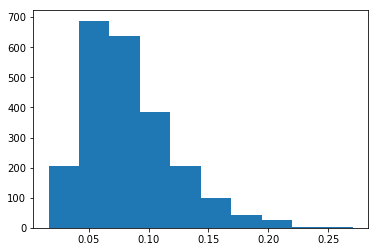

In [19]:
plt.hist(uniformity[mask])

In [24]:
slicer_area = slicers.HealpixSlicer(nside=64, lonCol='fieldRA', latCol='fieldDec', latLonDeg=True)
uniformity_metric = metrics.UniformityMetric(surveyLength=10)
sql = 'proposalId = 3 and filter = "r"'

plotDict={'figsize':(10,8), 'title' :  'Full 10 Years - Standard Uniformity Metric',
          'colorMin':0, 'colorMax': 0.18, 'xMin':0., 'xMax':0.18,
         'bins' : np.arange(0.,0.18,0.02)-0.01}
# bundle_group = {'full_10years' : mb.MetricBundle(uniformity_metric, slicer_area, sql,
#                                                  plotDict=plotDict)}

# Using surveyLength=0.5 beacause each field is optimally observed for roughly ~6 months
filter_list = ['r', 'g', 'i', 'z', 'y']
bundle_group = {}
for obs_filter in filter_list:
    uniformity_metric = metrics.UniformityMetric(surveyLength=10)
    sql = 'proposalId = 3 and filter = "%s"' % (obs_filter)

    plotDict['title'] = 'Full 10 Years - Filter %s' % (obs_filter)
    bundle_group['full_10years_filter_%s' % (obs_filter)] = mb.MetricBundle(uniformity_metric,
                                                                            slicer_area,
                                                                            sql,
                                                                            plotDict=plotDict)

    
    for year in range(10):
        plotDict['title'] = 'Season %i Uniformity Metric - Filter %s' % (year+1, obs_filter)
        sql = 'proposalId = 3 and night < %i and filter = "%s"' % ((year+1)*365, obs_filter)    
        uniformity_metric = SeasonUniformityMetric(surveyLength=1.0, season=year) 
        bundle_group['season_%02i_filter_%s' % (year+1, obs_filter)] = mb.MetricBundle(uniformity_metric, 
                                                                 slicer_area, 
                                                                 sql,
                                                                 plotDict=plotDict)

bg = mb.MetricBundleGroup(bundle_group, o)
bg.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint proposalId = 3 and night < 3285 and filter = "y" for columns ['fieldRA', 'fieldDec', 'observationStartMJD']
Found 374450 visits
Running:  ['season_09_filter_y']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and night < 1825 and filter = "r" for columns ['fieldRA', 'fieldDec', 'observationStartMJD']
Found 206242 visits
Running:  ['season_05_filter_r']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and night < 1460 and filter = "r" for columns ['fieldRA', 'fieldDec', 'observationStartMJD']
Found 163561 visits
Running:  ['season_04_filter_r']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying databas

Found 191248 visits
Running:  ['full_10years_filter_g']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and night < 2555 and filter = "r" for columns ['fieldRA', 'fieldDec', 'observationStartMJD']
Found 298303 visits
Running:  ['season_07_filter_r']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and night < 730 and filter = "i" for columns ['fieldRA', 'fieldDec', 'observationStartMJD']
Found 61795 visits
Running:  ['season_02_filter_i']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 and filter = "i" for columns ['fieldRA', 'fieldDec', 'observationStartMJD']
Found 435814 visits
Running:  ['full_10years_filter_i']
Completed metric generation.
Running reduce methods

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [25]:
plotDict={'figsize':(10,8)}
bg.plotAll()

Plotting figures with "proposalId = 3 and night < 3285 and filter = "y"" constraint now.
monopole: 0.074314  dipole: lon: 170.039, lat: -0.19024, amp: 0.0162948
Plotting complete.
Plotting figures with "proposalId = 3 and night < 1825 and filter = "r"" constraint now.
monopole: 0.0875406  dipole: lon: -176.726, lat: 39.4577, amp: 0.0310778
Plotting complete.
Plotting figures with "proposalId = 3 and night < 1460 and filter = "r"" constraint now.
monopole: 0.0775878  dipole: lon: -155.386, lat: 19.6581, amp: 0.0206209
Plotting complete.
Plotting figures with "proposalId = 3 and filter = "r"" constraint now.
monopole: 0.0893598  dipole: lon: -23.914, lat: -23.5194, amp: 0.0188401
Plotting complete.
Plotting figures with "proposalId = 3 and night < 2190 and filter = "y"" constraint now.
monopole: 0.0872243  dipole: lon: -116.711, lat: 20.527, amp: 0.0366128
Plotting complete.
Plotting figures with "proposalId = 3 and filter = "z"" constraint now.
monopole: 0.115371  dipole: lon: 165.727, 

Plotting complete.
Plotting figures with "proposalId = 3 and night < 2190 and filter = "g"" constraint now.
monopole: 0.0597655  dipole: lon: -174.509, lat: 23.1169, amp: 0.0419151
Plotting complete.
Plotting figures with "proposalId = 3 and night < 2920 and filter = "y"" constraint now.
monopole: 0.107966  dipole: lon: -101.332, lat: 47.5737, amp: 0.0575687
Plotting complete.
Plotting figures with "proposalId = 3 and night < 2920 and filter = "g"" constraint now.
monopole: 0.0660476  dipole: lon: -143.289, lat: 2.71104, amp: 0.025707
Plotting complete.
Plotting figures with "proposalId = 3 and night < 2190 and filter = "z"" constraint now.
monopole: 0.0936958  dipole: lon: -149.669, lat: 47.9765, amp: 0.0274619
Plotting complete.
Plotting figures with "proposalId = 3 and night < 3285 and filter = "g"" constraint now.
monopole: 0.068517  dipole: lon: -142.313, lat: 10.5306, amp: 0.0400034
Plotting complete.
Plotting figures with "proposalId = 3 and night < 1095 and filter = "r"" constr